# CNN天气识别 

## 读取数据的方法1

### 导包  

In [2]:
import torch
from torch.utils.data import TensorDataset,DataLoader 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt 
import shutil 
import os 
import torchvision

### ❗ 从分类文件夹中创建dataset数据 

ImageFolder要求`一个类别是一个文件夹`,所以我们需要把一整块图片先划分开来

```python 
torchvision.datasets.ImageFolder()
```

#### 先整理数据集

In [ ]:
base_dir = r'./4weather'

In [ ]:
if not os.path.isdir(base_dir):  #如果不存在就先创建
    os.mkdir(base_dir)
    train_dir = os.path.join(base_dir,'train') #创建训练集 
    test_dir = os.path.join(base_dir,'test') #创建测试集 
    print(train_dir)
    os.mkdir(train_dir)
    os.mkdir(test_dir)

In [ ]:
ClAsses = ['cloudy','rain','shine','sunrise']
for train_or_test in ['train','test']: 
    for cls in ClAsses: 
        a_path = os.path.join(base_dir,train_or_test)
        b_path = os.path.join(a_path,cls)
        print(b_path)
        os.mkdir(b_path)

        #或者直接写 os.mkdir(os.path.join(base_dir,ttrain_or_test,cls))
    

#### 将图片分类到对应的文件夹   

In [ ]:
img_dir= r'./dataset2' 

In [ ]:
os.listdir(img_dir) 

In [ ]:
for i,img in enumerate(os.listdir(img_dir)): 
    #对图片进行分类 
    for cls in ClAsses:
        if cls in img: #检查当前图片文件名（img）中是否包含类别字符串（cls）。
            s = os.path.join(img_dir,img) #原始图片路径
            if i%5==0: #如果索引可以被5整除,那就划分到测试集里
                d = os.path.join(base_dir,'test',cls,img) #将图片放到各自对应的类别当中  
                print(d)
            else:
                d = os.path.join(base_dir,
                             'train'
                             ,cls,img) #如果不可以被5整除,那就划分为训练集
            shutil.copy(s,d)
        
    

#### 分好之后查看一下每个文件的所含图片的数量

In [ ]:
for train_or_test in ['train','test']: 
    for cls in ClAsses: 
        print(train_or_test,cls,len(os.listdir(os.path.join(base_dir,train_or_test,cls))))

### 读取,预处理并创建Dataset 

In [4]:
from torchvision import transforms

In [5]:
transform=transforms.Compose(
    [
        transforms.Resize((96,96)), #转换图片尺寸  
        transforms.ToTensor(), ## 将PIL图像或numpy数组转换为PyTorch张量，并将像素值归一化到[0,1]
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]) #把数据范围从 [0,1] 映射到 [-1,1]。# 对每个通道进行标准化处理，使数据分布范围变为 [-1,1]，有助于模型训练
    ]
    
)

In [6]:
Train_DS = torchvision.datasets.ImageFolder(
    '4weather/train', 
    transform=transform
)

In [7]:
Tst_DS = torchvision.datasets.ImageFolder(
    '4weather/test', 
    transform=transform
)

In [8]:
Train_DS.classes

['cloudy', 'rain', 'shine', 'sunrise']

In [9]:
Tst_DS.classes

['cloudy', 'rain', 'shine', 'sunrise']

In [10]:
Train_DS.class_to_idx,len(Train_DS)

({'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}, 900)

In [11]:
Tst_DS.class_to_idx,len(Tst_DS)

({'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}, 225)

### 创建DataLoader 

In [12]:
Train_DL = DataLoader(Train_DS,batch_size=32,shuffle=True)
Tst_DL = DataLoader(Tst_DS,batch_size=64,shuffle=False)

#### 拿出一个批次的数据查看

In [11]:
imgs,labels = next(iter(Train_DL))

In [12]:
imgs.shape #批量大小32,3个通道(rgb),高96px,宽96px

torch.Size([32, 3, 96, 96])

In [13]:
imgs[0].shape

torch.Size([3, 96, 96])

In [14]:
im = imgs[0].permute(1,2,0) #让[3,96,96] (c,h,w)（0，1，2） 转变成[96,96,3](h,w,c)（1，2，0） 方便我们使用matplotlib绘图
im.shape

torch.Size([96, 96, 3])

#### 绘制

由于刚才的transform将其normalize到了-1-1之间,所以我们需要将其还原为0-1之间,也就是让转换后的数据+1再/2

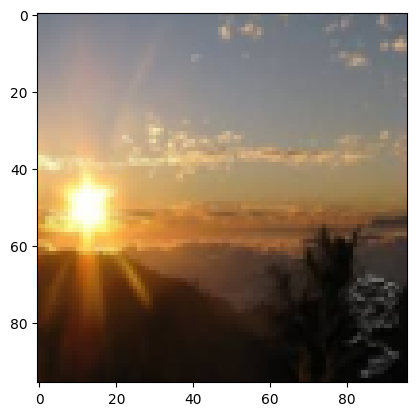

In [15]:
im = im.numpy()
im = (im+1)/2
plt.imshow(im) #转换成np类型并绘图

In [16]:
labels[0]

tensor(3)

可以看到对应上了class_to_idx中的sunrise

#### 让类别数值转换为类别

In [13]:
Train_DS.class_to_idx.items()

dict_items([('cloudy', 0), ('rain', 1), ('shine', 2), ('sunrise', 3)])

将类别对应关系的dict_items这个列表中的元组转换为字典

In [14]:
id_to_class = dict((v,k) for k,v in Train_DS.class_to_idx.items())

In [15]:
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

#### 简单查看

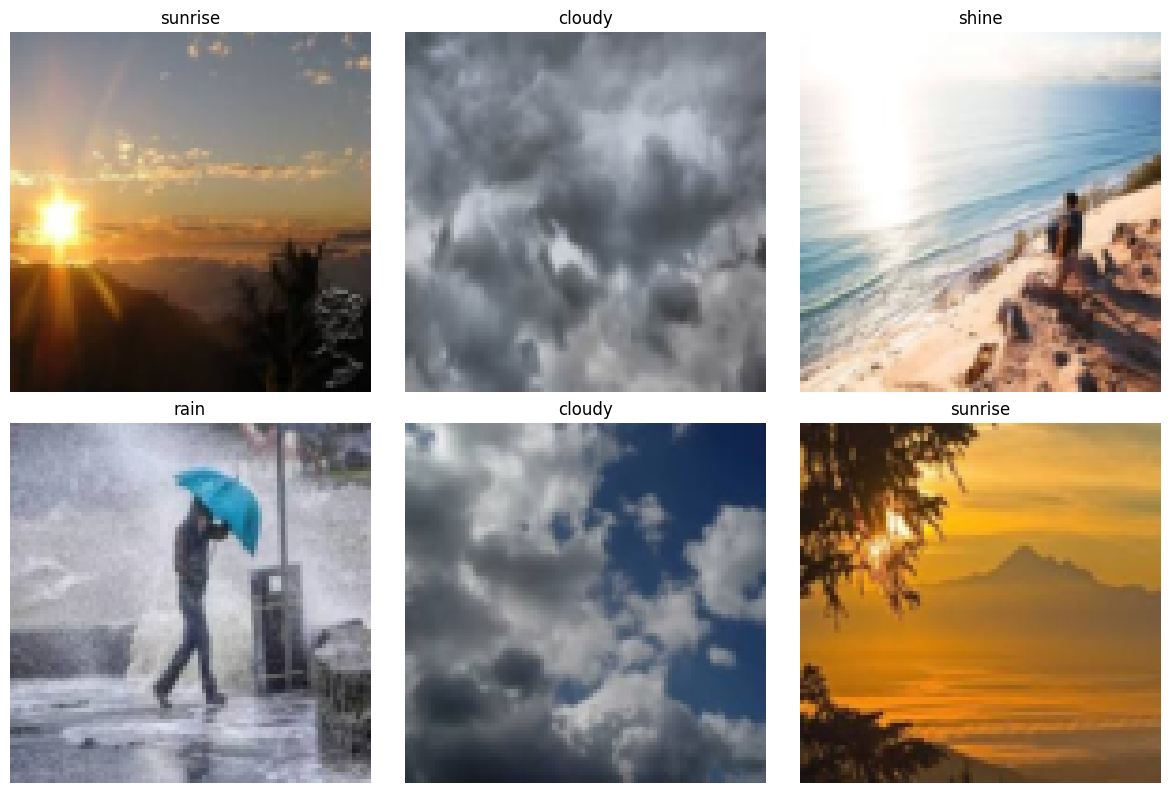

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# 遍历前6个样本
for i in range(6):
    img = imgs[i]  # 获取第i张图像 (3, 96, 96)
    label = labels[i].item()  # 转换为Python标量
    
    # 将图像从 [C, H, W] 转为 [H, W, C] 并还原到 [0,1] 范围
    img = (img.permute(1, 2, 0).numpy() + 1) / 2  # Normalize反归一化到[0,1]
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(id_to_class[label])  # 假设你有一个 id_to_class 字典
    plt.axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

### 创建模型 

In [16]:
 class Net(nn.Module): 
    def __init__(self):
         super().__init__()  
         #初始化卷积层  
         self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3) #使用6个卷积核，卷积核大小为5*5
         #设置第二个卷积层
         self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3)  #第一个卷积层是6个输出channels,所以第二个卷积层的输入channel大小是第一个卷积层的输入大小
         #设置第三个卷积层 
         self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
         #设置池化层
         self.pool = nn.MaxPool2d(kernel_size=(2,2))  #设置池化核为2*2 ,也就是四个格子里选出一个,原来的是28*28的,然后会变成14*14的
         
         #设置全连接层
         
         self.fc1 = nn.Linear(20*20*64,1024) #展平,自己算的
         self.fc2 = nn.Linear(1024,256) 
         self.fc3 = nn.Linear(256,4) #4类天气
    def forward(self, x):
        # 第一层卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv1(x))) 
        
        # 第二层卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv2(x))) 
        #第三层卷积+激活
        x = F.relu(self.conv3(x)) 
          
        # 展平为一维向量
        #x = x.view(-1, 20*20*64)  
        x = torch.flatten(x,1)

        # 全连接层
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))     
        x = self.fc3(x)      

        return x

In [22]:
model = Net() 

In [23]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

### 开训

#### 创建训练方法

In [17]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


#### 创建损失函数等

In [25]:
lr = 0.001 
loss_fn = nn.CrossEntropyLoss() 
optim = torch.optim.Adam(model.parameters(),lr=lr)

train_loss_gpu=[] 
train_acc_gpu =[]  
tst_loss_gpu = [] 
tst_acc_gpu=[] 
epochs = 20
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=Train_DL,TST_DL=Tst_DL,Model_m=model,epoch_=epoch,optim=optim,loss_fn=loss_fn)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)

epoch:0 | loss:0.025 | acc:0.620 | tstloss:0.009 | tstacc:0.822
epoch:1 | loss:0.016 | acc:0.787 | tstloss:0.008 | tstacc:0.844
epoch:2 | loss:0.013 | acc:0.831 | tstloss:0.009 | tstacc:0.836
epoch:3 | loss:0.011 | acc:0.857 | tstloss:0.008 | tstacc:0.907
epoch:4 | loss:0.009 | acc:0.896 | tstloss:0.008 | tstacc:0.898
epoch:5 | loss:0.009 | acc:0.890 | tstloss:0.008 | tstacc:0.884
epoch:6 | loss:0.006 | acc:0.912 | tstloss:0.010 | tstacc:0.893
epoch:7 | loss:0.005 | acc:0.941 | tstloss:0.011 | tstacc:0.893
epoch:8 | loss:0.004 | acc:0.949 | tstloss:0.013 | tstacc:0.902
epoch:9 | loss:0.003 | acc:0.966 | tstloss:0.012 | tstacc:0.889
epoch:10 | loss:0.002 | acc:0.983 | tstloss:0.017 | tstacc:0.884
epoch:11 | loss:0.005 | acc:0.951 | tstloss:0.011 | tstacc:0.907
epoch:12 | loss:0.005 | acc:0.959 | tstloss:0.019 | tstacc:0.813
epoch:13 | loss:0.009 | acc:0.910 | tstloss:0.014 | tstacc:0.889
epoch:14 | loss:0.002 | acc:0.986 | tstloss:0.025 | tstacc:0.902
epoch:15 | loss:0.002 | acc:0.986 |

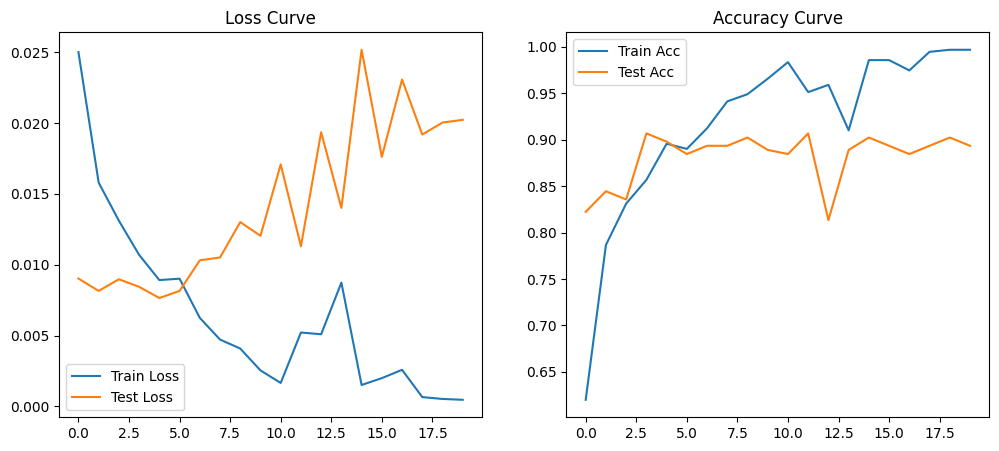

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_gpu, label='Train Loss')
plt.plot(tst_loss_gpu, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_gpu, label='Train Acc')
plt.plot(tst_acc_gpu, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

可以看到已经产生过拟合现象了

### 解决过拟合

#### dropout 简介   

Dropout 是一种在训练神经网络时用于抑制过拟合的有效技术。它由 Geoffrey Hinton 等人在 2012 年提出，并被广泛应用于各种深度学习模型中，特别是那些具有大量参数的深层网络。

#### Dropout 抑制过拟合的原理

##### 1. **随机失活神经元**

- 在每次训练迭代中，Dropout 会以一定的概率（通常是 0.5）随机“丢弃”网络中的某些神经元（即将它们的输出设置为零），这意味着这些神经元不会参与前向传播和反向传播。
- 这种做法相当于创建了一个“弱化版”的网络，因为部分神经元被暂时移除，减少了网络复杂度。
  
##### 2. **防止特征共适应**

- Dropout 防止了神经元之间的特征共适应（co-adaptation），即`避免了某些神经元过度依赖其他特定神经元的输出`。通过强制网络在不同的训练迭代中学习更鲁棒的特征表示，可以提高模型的泛化能力。
  
##### 3. **集成效应**

- 在训练过程中，由于每次迭代都会生成一个不同的“弱化版”网络结构，从某种意义上来说，这类似于训练了许多不同架构的子网络。
- 当进行预测时（测试阶段），所有的神经元都被激活（但通常会乘以 dropout 概率 p，例如 0.5，来平衡训练和测试时的输出尺度），这种做法可以看作是所有这些子网络的加权平均，从而获得类似集成学习的效果，进一步提升模型性能。

##### 4. **减少模型复杂度**

- Dropout 可以被视为一种正则化方法，它通过减少模型的有效容量来防止过拟合。虽然理论上完整的网络可能过于复杂以至于容易过拟合，但通过在训练期间随机丢弃一些单元，实际上降低了模型的复杂性，使得模型更加倾向于学习一般化的特征而非特定于训练数据集的细节。

#### 实现方式

在 PyTorch 中，你可以很容易地将 Dropout 应用到你的网络中：

```python
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # 添加 Dropout 层
        self.dropout = nn.Dropout(p=0.5)  # 设置丢弃概率
        
        self.fc1 = nn.Linear(64 * 20 * 20, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # 使用 Dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
```

#### 总结

Dropout 通过在训练过程中随机丢弃神经元来简化模型，防止过拟合并提高模型的泛化能力。它不仅能够降低单个模型的过拟合风险，还能够模拟出多个不同结构的模型效果，从而增强最终模型的表现。然而，在测试或推理阶段，所有的神经元都需要被使用，为了补偿训练时的丢失比例，通常会对激活值进行相应的缩放处理。

#### 定义带有Dropout的模型

In [30]:
import torch.nn as nn

class Net_with_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # 添加 Dropout 层
        self.dropout = nn.Dropout(p=0.5)  # 设置丢弃概率

        # 当然,也可以在卷积层添加dropout  
        self.dropout2d = nn.Dropout2d(p=0.5)
        
        self.fc1 = nn.Linear(64 * 20 * 20, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.Dropout2d(x)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # 使用 Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x) #使用dropout
        x = self.fc3(x)
        
        return x

#### 开训  

In [28]:
model = Net_with_dropout()  #实例化模型对象  
lr = 0.001
loss_fn = nn.CrossEntropyLoss() 
optim = torch.optim.Adam(model.parameters(),lr=lr)

train_loss_gpu=[] 
train_acc_gpu =[]  
tst_loss_gpu = [] 
tst_acc_gpu=[] 
epochs = 20
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=Train_DL,TST_DL=Tst_DL,Model_m=model,epoch_=epoch,optim=optim,loss_fn=loss_fn)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)

epoch:0 | loss:0.031 | acc:0.582 | tstloss:0.011 | tstacc:0.707
epoch:1 | loss:0.019 | acc:0.747 | tstloss:0.011 | tstacc:0.756
epoch:2 | loss:0.015 | acc:0.804 | tstloss:0.009 | tstacc:0.836
epoch:3 | loss:0.013 | acc:0.857 | tstloss:0.008 | tstacc:0.840
epoch:4 | loss:0.011 | acc:0.881 | tstloss:0.008 | tstacc:0.876
epoch:5 | loss:0.010 | acc:0.886 | tstloss:0.008 | tstacc:0.889
epoch:6 | loss:0.012 | acc:0.901 | tstloss:0.007 | tstacc:0.898
epoch:7 | loss:0.011 | acc:0.879 | tstloss:0.009 | tstacc:0.884
epoch:8 | loss:0.008 | acc:0.901 | tstloss:0.009 | tstacc:0.911
epoch:9 | loss:0.007 | acc:0.933 | tstloss:0.008 | tstacc:0.902
epoch:10 | loss:0.006 | acc:0.934 | tstloss:0.009 | tstacc:0.916
epoch:11 | loss:0.006 | acc:0.946 | tstloss:0.009 | tstacc:0.889
epoch:12 | loss:0.006 | acc:0.919 | tstloss:0.012 | tstacc:0.876
epoch:13 | loss:0.006 | acc:0.937 | tstloss:0.008 | tstacc:0.902
epoch:14 | loss:0.003 | acc:0.960 | tstloss:0.010 | tstacc:0.889
epoch:15 | loss:0.003 | acc:0.971 |

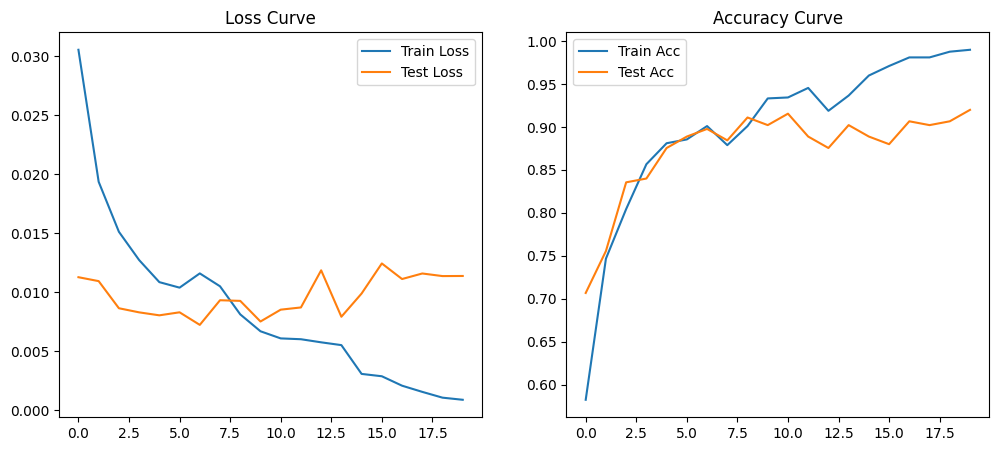

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_gpu, label='Train Loss')
plt.plot(tst_loss_gpu, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_gpu, label='Train Acc')
plt.plot(tst_acc_gpu, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

### BatchNormalization 

#### 定义新的模型 

In [18]:
class Net_with_dropout_and_batchnorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 卷积层 + 批标准化
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)  # 对应 conv1 输出通道数
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)  # 对应 conv2 输出通道数
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)  # 对应 conv3 输出通道数
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Dropout 层
        self.dropout = nn.Dropout(p=0.5)     # 全连接层用
        self.dropout2d = nn.Dropout2d(p=0.5) # 卷积层用（可选）

        # 全连接层 + 可选 BatchNorm1d
        self.fc1 = nn.Linear(64 * 20 * 20, 1024)
        self.bn1d1 = nn.BatchNorm1d(1024)  # 可选：对全连接层进行归一化
        
        self.fc2 = nn.Linear(1024, 256)
        self.bn1d2 = nn.BatchNorm1d(256)   # 可选
        
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        # 卷积块 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # 卷积块 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # 卷积块 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout2d(x)  # 可选的卷积层 dropout
        
        x = torch.flatten(x, 1)  # 展平
        
        # 全连接层
        x = F.relu(self.bn1d1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn1d2(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

In [19]:
model = Net_with_dropout_and_batchnorm()  

In [20]:
model

Net_with_dropout_and_batchnorm(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2d): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (bn1d1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn1d2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_fe

In [21]:
lr = 0.001 
loss_fn = nn.CrossEntropyLoss() 
optim = torch.optim.Adam(model.parameters(),lr=lr)

train_loss_gpu=[] 
train_acc_gpu =[]  
tst_loss_gpu = [] 
tst_acc_gpu=[] 
epochs = 10
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=Train_DL,TST_DL=Tst_DL,Model_m=model,epoch_=epoch,optim=optim,loss_fn=loss_fn)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)

epoch:0 | loss:0.028 | acc:0.658 | tstloss:0.010 | tstacc:0.818
epoch:1 | loss:0.018 | acc:0.792 | tstloss:0.006 | tstacc:0.884
epoch:2 | loss:0.016 | acc:0.820 | tstloss:0.006 | tstacc:0.902
epoch:3 | loss:0.014 | acc:0.827 | tstloss:0.005 | tstacc:0.898
epoch:4 | loss:0.011 | acc:0.874 | tstloss:0.005 | tstacc:0.893
epoch:5 | loss:0.011 | acc:0.880 | tstloss:0.005 | tstacc:0.884
epoch:6 | loss:0.011 | acc:0.878 | tstloss:0.005 | tstacc:0.911
epoch:7 | loss:0.010 | acc:0.910 | tstloss:0.005 | tstacc:0.911
epoch:8 | loss:0.010 | acc:0.893 | tstloss:0.006 | tstacc:0.902
epoch:9 | loss:0.012 | acc:0.908 | tstloss:0.005 | tstacc:0.907


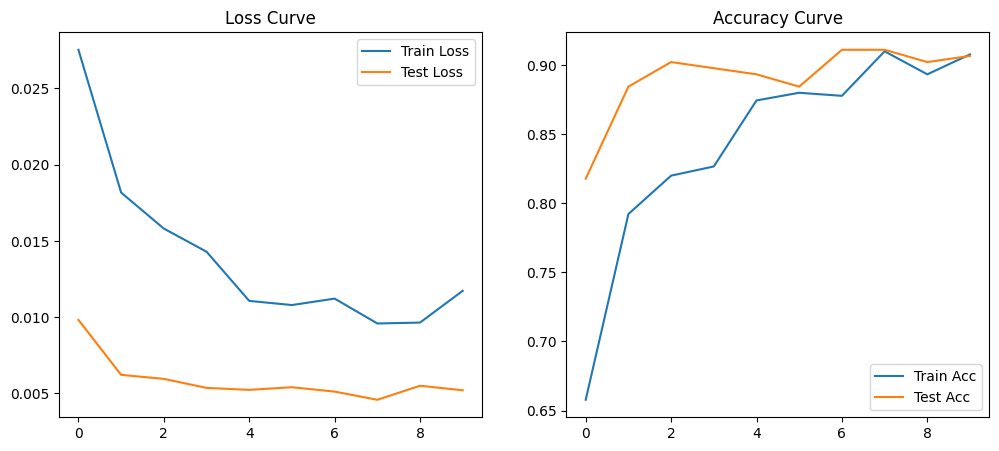

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_gpu, label='Train Loss')
plt.plot(tst_loss_gpu, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_gpu, label='Train Acc')
plt.plot(tst_acc_gpu, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

#### 保存模型 

In [23]:
# 保存模型参数
torch.save(model.state_dict(), './models/model_weights_NetwithBNandDO.pth')

# 加载模型参数
# model = models.resnet18()  # 必须先创建相同架构的模型
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()  # 设置为评估模式

#### 什么是批标准化（Batch Normalization）

批标准化（Batch Normalization，简称BN）是2015年由Sergey Ioffe和Christian Szegedy提出的一种优化技术。它旨在加速深度神经网络的训练过程，并稳定训练。批标准化通过对每一小批训练数据进行归一化处理，使得每层网络输入值具有零均值和单位方差，从而改善学习速率并减少梯度消失或爆炸的问题。

#### 为什么要进行批标准化

1. **加速训练**：通过归一化输入，可以使用更高的学习率，这有助于加快模型收敛速度。
2. **解决内部协变量偏移问题**：在深层网络中，每一层的输入分布会随着前一层参数的变化而变化，这种现象称为`内部协变量偏移`。批标准化减少了这种变化，使网络更稳定。
3. **减少对初始化的依赖**：批标准化降低了选择好的权重初始化的重要性。
4. **提供一定的正则化效果**：由于批标准化引入了噪声（因为是基于小批次的统计量），它可以起到类似Dropout的作用，帮助防止过拟合。
5. **缓解梯度消失/爆炸问题**：通过保持激活函数的输入在一个合理范围内，避免了梯度消失或爆炸的问题，尤其是在很深的网络中。

#### 如何进行批标准化

在实践中，批标准化通常是在神经网络的每个（或选定的）隐藏层之后、非线性激活函数之前应用。下面是批标准化的基本步骤：

1. **计算小批量的均值和方差**：对于给定的小批量输入数据，计算其均值和方差。
2. **归一化**：使用上述计算出的均值和方差来归一化输入数据，使其具有零均值和单位方差。
3. **缩放和平移**：引入两个可学习的参数γ（缩放因子）和β（平移因子），以恢复网络的表达能力，即允许网络学习最优的数据分布。

在PyTorch中，可以通过`torch.nn.BatchNorm1d`, `torch.nn.BatchNorm2d`, 或者 `torch.nn.BatchNorm3d`根据你的数据维度来添加批标准化层。例如，在卷积神经网络中，可以在卷积层后添加批标准化层：

```python
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # 对应conv1输出的通道数
        
        # 其他层...
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # 继续其他操作...
        return x
```

这段代码展示了如何在卷积层后添加批标准化层，并在前向传播过程中使用它。这样做的目的是为了确保进入激活函数的数据具有良好的分布特性，从而提高训练效率和模型性能。

好的！你原来的代码已经实现了 **Dropout**，现在你想加上 **批标准化（Batch Normalization）** 来进一步提升模型的训练速度和稳定性。

---

### ✅ 本次修改目标：

- 在卷积层后添加 `BatchNorm2d`。
- 在全连接层后添加 `BatchNorm1d`（可选）。
- 修正你代码中的一些小错误（如 `self.Dropout2d(x)` 应为 `self.dropout2d(x)`）。
- 最终实现一个包含 **Dropout + BatchNorm** 的 CNN 模型。

---

### ✅ 修改后的完整代码如下：

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net_with_dropout_and_batchnorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 卷积层 + 批标准化
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)  # 对应 conv1 输出通道数
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)  # 对应 conv2 输出通道数
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)  # 对应 conv3 输出通道数
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Dropout 层
        self.dropout = nn.Dropout(p=0.5)     # 全连接层用
        self.dropout2d = nn.Dropout2d(p=0.5) # 卷积层用（可选）

        # 全连接层 + 可选 BatchNorm1d
        self.fc1 = nn.Linear(64 * 20 * 20, 1024)
        self.bn1d1 = nn.BatchNorm1d(1024)  # 可选：对全连接层进行归一化
        
        self.fc2 = nn.Linear(1024, 256)
        self.bn1d2 = nn.BatchNorm1d(256)   # 可选
        
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        # 卷积块 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # 卷积块 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # 卷积块 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout2d(x)  # 可选的卷积层 dropout
        
        x = torch.flatten(x, 1)  # 展平
        
        # 全连接层
        x = F.relu(self.bn1d1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn1d2(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x
```

---

### 📌 关键说明

| 组件 | 作用 |
|------|------|
| `nn.BatchNorm2d(n)` | 用于卷积层输出，n 是通道数 |
| `nn.BatchNorm1d(n)` | 用于全连接层输出，n 是神经元个数 |
| `nn.Dropout(p)` | 防止过拟合，在全连接层之间使用效果最好 |
| `nn.Dropout2d(p)` | 用于卷积层输出，随机丢弃整个通道（特征图），比普通 Dropout 更适合卷积层 |

---

### ✅ 推荐实践建议

- **BatchNorm 放在卷积或全连接层之后、激活函数之前**（即 `conv -> bn -> relu`）。
- **Dropout 通常放在激活函数之后**，防止某些神经元过度依赖。
- 如果你发现模型仍然容易过拟合，可以：
  - 增加 Dropout 概率（比如从 0.5 到 0.6）
  - 添加更多 BatchNorm 或 LayerNorm
  - 使用 L2 正则化（weight decay）
  - 增加数据增强（Data Augmentation）

---

### ✅ 总结一句话：

> **你现在的网络结构已经不错了，通过加入 `BatchNorm2d` 和 `BatchNorm1d`，再加上合理的 Dropout，能显著提升训练效率和泛化能力。**

如果你愿意提供训练结果或损失曲线，我还可以帮你进一步调参 😊

## 一些疑问

你这段代码中，**展平（flatten）的部分写错了**，导致整个网络在前向传播时会出错。

---

### 🔍 问题定位

你定义了三层卷积层：

```python
self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
```

然后你在 `forward` 中这样展平：

```python
x = x.view(-1, 16 * 4 * 4)  
```

这个是 **错误的**。因为你最后输出的是 `64` 个通道（来自 `conv3`），而不是 `16`。

而且根据你前面的卷积和池化操作，张量的尺寸也不是 `4x4`，实际计算后是 **20x20**，所以你的展平部分与实际维度不匹配。

---

### ✅ 正确做法：理解每一步的尺寸变化

我们来一步一步看输入输出的尺寸变化。

假设输入图像大小为 `(3, 96, 96)`（即 batch 不算，只看 channel、height、width）

#### 第一层：`conv1 + relu + pool`

- `conv1`: `in_channels=3`, `out_channels=16`, `kernel_size=3`
  - 输入: `(96 - 3 + 0)/1 + 1 = 94`
  - 输出: `(16, 94, 94)`
- `relu`: 不改变形状
- `pool (2x2)`: stride 默认是 2
  - 输出: `(16, 47, 47)`（因为 94 / 2 = 47）

#### 第二层：`conv2 + relu + pool`

- `conv2`: `in_channels=16`, `out_channels=32`, `kernel_size=3`
  - 输入: `(47 - 3 + 0)/1 + 1 = 45`
  - 输出: `(32, 45, 45)`
- `relu`: 不变
- `pool`: `(32, 22, 22)`（因为 45 / 2 = 22.5，向下取整为 22）

#### 第三层：`conv3 + relu + pool`

- `conv3`: `in_channels=32`, `out_channels=64`, `kernel_size=3`
  - 输入: `(22 - 3 + 0)/1 + 1 = 20`
  - 输出: `(64, 20, 20)`
- `relu`: 不变
- `pool`: 这里你没写池化！如果加上池化：
  - 输出变为 `(64, 10, 10)`

---

### 📌 所以你有两个选择：

#### ✅ 方法一：如果你 **没有** 在第三层加池化

- 输出是 `(64, 20, 20)`
- 展平应为：`x.view(-1, 64 * 20 * 20)` 即 `x.view(-1, 25600)`

#### ✅ 方法二：如果你在第三层之后也加了池化

- 输出是 `(64, 10, 10)`
- 展平应为：`x.view(-1, 64 * 10 * 10)` 即 `x.view(-1, 6400)`

---

### ❌ 另外一个小错误：

你在 `forward` 最后调用了 `self.fc3(x)`，但你并没有定义 `self.fc3`！

你只定义了：

```python
self.fc1 = nn.Linear(20*20*64, 1024)
self.fc2 = nn.Linear(1024, 4)
```

所以这行代码：

```python
x = self.fc3(x)
```

会导致报错。

---

### ✅ 修改后的完整 forward 函数（方法一）：

```python
def forward(self, x):
    # 第一层卷积 + 激活 + 池化
    x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 16, 47, 47]
    
    # 第二层卷积 + 激活 + 池化
    x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 32, 22, 22]
    
    # 第三层卷积 + 激活 + 池化（可选）
    x = F.relu(self.conv3(x))             # -> [batch, 64, 20, 20]

    # 展平
    x = x.view(-1, 64 * 20 * 20)          # 正确展平
    
    # 全连接层
    x = F.relu(self.fc1(x))               # -> [batch, 1024]
    x = self.fc2(x)                       # -> [batch, 4]

    return x
```

---

### 📝 总结

| 问题 | 原因 | 解决方案 |
|------|------|----------|
| `x.view(-1, 16 * 4 * 4)` 错误 | 维度不对 | 改为 `x.view(-1, 64 * 20 * 20)` |
| `self.fc3` 不存在 | 没有定义 | 删除最后一行 `x = self.fc3(x)` |
| 网络结构不清楚 | 缺少注释 | 加上每一步的 shape 注释 |

---

如果你想要更自动地计算 flatten 的维度，可以使用如下方式：

```python
print(x.shape)  # 调试用，查看当前 tensor 形状
```

或者使用 `torch.flatten()`：

```python
x = torch.flatten(x, 1)  # 展平除 batch 外的所有维度
```

---

如需我帮你改写成更清晰的 CNN 结构，也可以继续问我 😊

你这个问题非常棒，说明你在深入理解模型结构的同时，也在思考如何让代码更自动化、更灵活！

---

### ✅ 你的问题总结：

> 虽然 `torch.flatten(x, 1)` 可以自动展平张量，但我在定义全连接层时仍然手动写了：
>
> ```python
> self.fc1 = nn.Linear(64 * 20 * 20, 1024)
> ```
>
> **有没有办法也能让这一步自动计算这个输入维度？**

---

### ✅ 答案：**可以！**

你可以通过构造一个“虚拟输入”并让它前向传播一小步，来自动获取展平后的维度。这种方法在构建 CNN 时非常常见，也适用于你的场景。

---

### 🚀 自动计算展平后尺寸的方法（推荐）

#### ✅ 方法一：添加一个函数，在初始化时自动计算 flatten 后的大小

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): 
    def __init__(self):
        super().__init__()  
        
        # 卷积层
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        # 自动计算全连接层输入大小
        fc1_input_dim = self._get_fc_input_dim()

        # 全连接层
        self.fc1 = nn.Linear(fc1_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def _get_fc_input_dim(self):
        # 创建一个虚拟输入 (batch_size=1, channels=3, H=96, W=96)
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            x = self._forward_conv(dummy_input)
            x = torch.flatten(x, 1)
            return x.shape[1]

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))     
        x = self.fc3(x)      
        return x
```

---

### 🔍 这个方法的优点：

- ✅ 不用手动计算展平后的维度（如 `64*20*20`）
- ✅ 更加健壮，即使你修改了卷积层参数（如 kernel size、input size），它也能自动适应
- ✅ 更加模块化，适合做模型重构或复用

---

### 💡 小贴士：如果你不想改模型结构，也可以在运行时打印维度调试

比如在 `forward` 中临时加入：

```python
print(f"Shape before flatten: {x.shape}")
```

这样你就能看到实际输出形状，从而确定 `Linear` 层的输入大小。

---

### ✅ 总结

| 手动写法 | 自动写法 |
|----------|-----------|
| `self.fc1 = nn.Linear(64*20*20, 1024)` | ✅ 使用 `_get_fc_input_dim()` 函数自动计算 |
| 容易出错、不够灵活 | ✅ 更加通用、易于维护 |

---

如果你将来想扩展模型（比如换图像尺寸、增加更多层），这种自动推导的方式会特别有用 👍

需要我帮你改成带 Dropout、BatchNorm 或者可视化网络结构，也可以继续问我 😄